# **Projeto Petrobrás**

## Desafio

Desenvolver uma aplicação que seja capaz de
realizar a classificação do ciclo, como sendo:
“normal”, “alerta” ou “anômalo”. Utilizando
como entradas os features “campanha” e/ou
“resistência”.

*   Com os dados de teste, ap.: matriz de confusão,
acurácia, score F1;
*   Com os dados de treinamento, ap.: plotar a
curva de aprendizado


## **PRÉ-PROCESSAMENTO DOS DADOS**


descrição do dataset:
         Unnamed: 0    campaign_E  resistance_E       cycle_E
count  17268.000000  17268.000000  17268.000000  17268.000000
mean   23111.483264   3344.230495      0.012665     26.856382
std    13372.423051   3252.839529      0.008188     22.383915
min        0.000000      4.544912      0.001649      0.000000
25%    13618.750000    948.270051      0.006139     12.000000
50%    25842.500000   2461.632067      0.008878     15.000000
75%    36547.250000   4528.089014      0.018012     39.000000
max    41017.000000  16741.986596      0.057695     84.000000

Número de valores nulos:
Unnamed: 0      0
campaign_E      0
resistance_E    0
cycle_E         0
target_cycle    0
dtype: int64


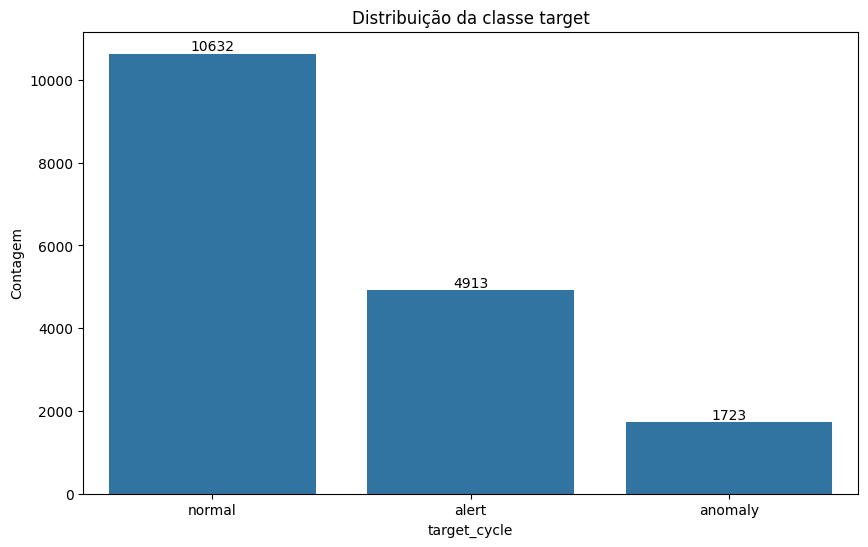

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, learning_curve,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Carregar o dataset
dataset_path = '../dataset/dataset_carbon_filter.csv'
df = pd.read_csv(dataset_path)

# Informações sobre o dataset
print(f'\ndescrição do dataset:\n{df.describe()}')
print(f'\nNúmero de valores nulos:\n{df.isnull().sum()}')

# Verificar a distribuição da classe target
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='target_cycle', data=df)

# Adicionar os valores dentro das barras
ax.bar_label(ax.containers[0])

plt.title('Distribuição da classe target')
plt.xlabel('target_cycle')
plt.ylabel('Contagem')
plt.show()



## **CORRELAÇÃO** 

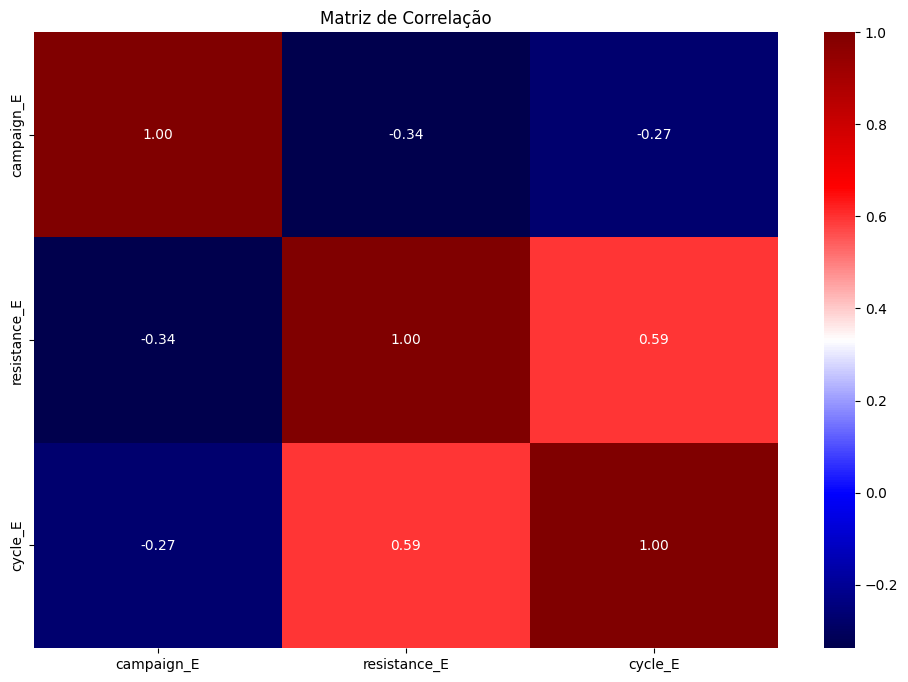

In [3]:
data = df.copy()
data = data.drop(columns=['Unnamed: 0'])
numeric_df = data.select_dtypes(include=[np.number])

# Calcular a matriz de correlação
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='seismic', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

## **TREINAMENTO**

In [4]:
# Separar as features e o target
X = df[['campaign_E', 'resistance_E']]
y = df['target_cycle']

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Ajustar o modelo aos dados
grid_search.fit(X_train, y_train)

# Resultados
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Melhores parâmetros: {best_params}')
print(f'Melhor pontuação de acurácia na validação cruzada: {best_score*100:.2f}%')

Melhores parâmetros: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Melhor pontuação de acurácia na validação cruzada: 98.49%


## **AVALIAÇÃO DO MODELO**

classification report:
              precision    recall  f1-score   support

       alert       0.97      0.97      0.97       989
     anomaly       0.99      0.98      0.99       348
      normal       0.99      0.99      0.99      2117

    accuracy                           0.98      3454
   macro avg       0.98      0.98      0.98      3454
weighted avg       0.98      0.98      0.98      3454

Acurácia: 98.20%
F1 Score: 98.21%



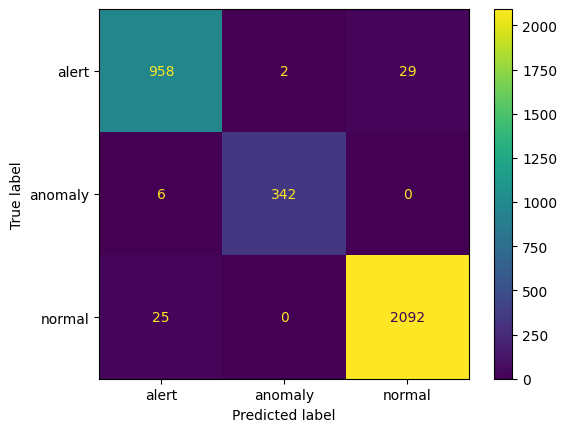

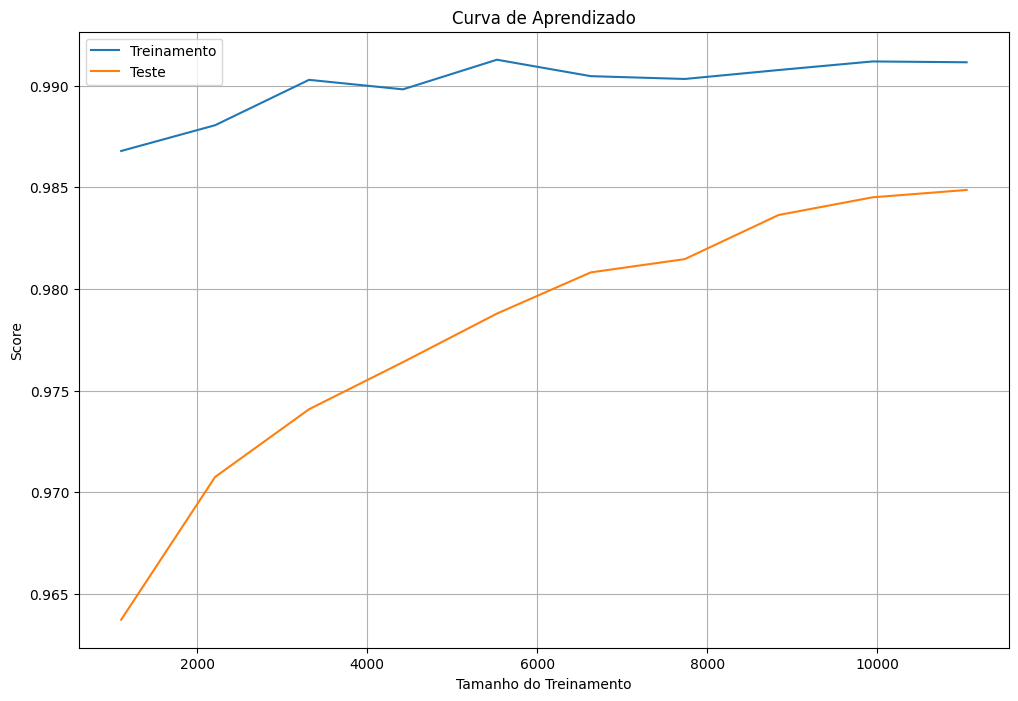

In [6]:

# Avaliação do modelo com os melhores parâmetros encontrados
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# classification report
print(f'classification report:\n{classification_report(y_test, y_pred)}')

print(f'Acurácia: {accuracy*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%\n')

# Plotar matriz de confusão
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show()

# Plotar a curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(12, 8))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Treinamento')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Teste')
plt.title('Curva de Aprendizado')
plt.xlabel('Tamanho do Treinamento')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()